In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Better veg and climate plots

In [5]:
df2 = pd.read_csv("machine_readable_review.csv")
df2.columns

Index(['Study', 'DOI', 'region_code', 'Subregion (Upper Kup= 9 ; Imn = 17)',
       'slope_degrees_min', 'slope_degrees_max', 'maat_min', 'maat_max',
       'map_total', 'map_rain', 'map_snow', 'Sarah CAVM veg community',
       'Sarah Koppen', 'Latitude (N)', 'Longitude (E)', 'defs'],
      dtype='object')

c:\Users\jdelvecchio01\AppData\Local\miniconda3\envs\geobasic\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jdelvecchio01\AppData\Local\miniconda3\envs\geobasic\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jdelvecchio01\AppData\Local\miniconda3\envs\geobasic\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jdelvecchio01\AppData\Local\miniconda3\envs\geobasic\lib\site-packages\seaborn\_ol

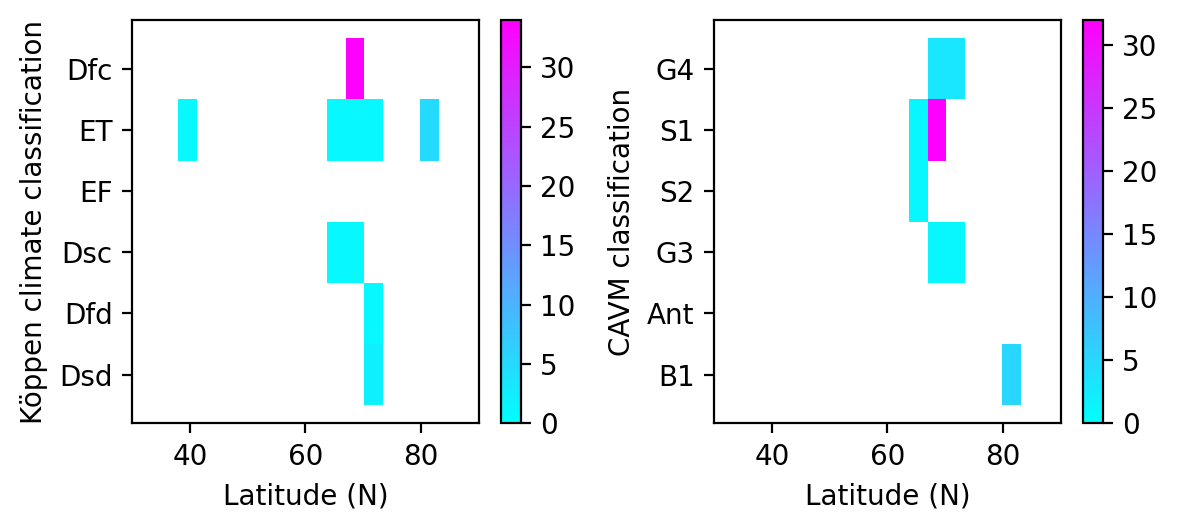

In [6]:
num_bins = 50
fig, ax = plt.subplots(1,2, figsize=(6,2.75), dpi=200)
sns.histplot(ax=ax[0],
              data=df2,
                x='Latitude (N)',
                  # y='Vegetation community https://nsidc.org/data/ggd639/versions/1 ',
                  y='Sarah Koppen',
                  # hue='Latitude (N)',
                  cmap='cool',
                  bins=num_bins,
                  cbar=True),
sns.histplot(ax=ax[1],
              data=df2,
                x='Latitude (N)',
                  # y='Vegetation community https://nsidc.org/data/ggd639/versions/1 ',
                  y='Sarah CAVM veg community',
                  # hue='Latitude (N)',
                  cmap='cool',
                  bins=num_bins,
                  cbar=True),
ax[0].set_xlim(30,90)
ax[1].set_xlim(30,90)
ax[0].set_ylabel("Köppen climate classification")
ax[1].set_ylabel("CAVM classification")
fig.tight_layout()

# Map(s)

In [7]:
gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df2['Longitude (E)'], df2['Latitude (N)']), crs='epsg:4326')

antarctica = gpd.read_file('geoBoundaries-ATA-ADM0_simplified.geojson')
arctic = gpd.read_file('Major_Ocean_Currents.geojson')
# arctic = arctic.loc[arctic['COMBO'] !='o'].dissolve()

# print(antarctica.crs)
# print(arctic.crs)

In [8]:
arctic_buffers = gpd.GeoDataFrame(
    gdf.loc[gdf['Latitude (N)'] > 0].dropna(subset='Latitude (N)'),
    geometry = gdf.loc[gdf['Latitude (N)'] > 0].dropna(subset='Latitude (N)').to_crs("EPSG:3411").buffer(100000).to_crs("EPSG:4326"),
)
antarctic_buffers = gpd.GeoDataFrame(
    gdf.loc[gdf['Latitude (N)'] < 0].dropna(subset='Latitude (N)'),
    geometry = gdf.loc[gdf['Latitude (N)'] < 0].dropna(subset='Latitude (N)').to_crs("EPSG:3031").buffer(100000).to_crs("EPSG:4326")
)

In [9]:
arctic_overlaps = gpd.GeoDataFrame(
    arctic_buffers.join(
    gpd.sjoin(gdf.loc[gdf['Latitude (N)'] > 0].dropna(subset='Latitude (N)'), arctic_buffers).groupby("index_right").size().rename("points"),
    how="left",
),
geometry = gdf.loc[gdf['Latitude (N)'] > 0].dropna(subset='Latitude (N)').geometry
)
# arctic_overlaps['points'].value_counts()

antarctic_overlaps = gpd.GeoDataFrame(
    antarctic_buffers.join(
    gpd.sjoin(gdf.loc[gdf['Latitude (N)'] < 0].dropna(subset='Latitude (N)'), antarctic_buffers).groupby("index_right").size().rename("points"),
    how="left",
),
geometry = gdf.loc[gdf['Latitude (N)'] < 0].dropna(subset='Latitude (N)').geometry
)

(-5000000.0, 5000000.0)

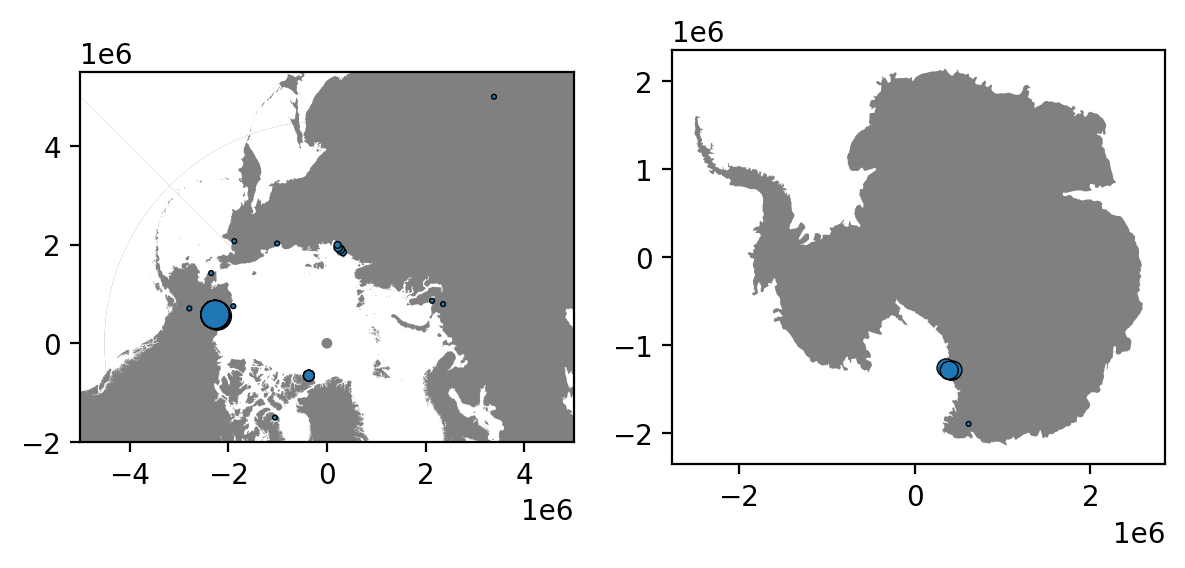

In [10]:
fig, ax = plt.subplots(1,2, figsize=(7,7), dpi=200)

antarctica.to_crs('EPSG:3031').plot(
    # z=0,
                 ax=ax[1],
                 color='gray',
                 zorder=0
                 )

antarctic_overlaps.to_crs('EPSG:3031').plot(markersize=antarctic_overlaps['points']*3,
                                         edgecolor='k', linewidth=0.5,
                     ax=ax[1]
                     )

arctic.loc[arctic['COMBO'] =='o'].to_crs('EPSG:3411').plot(
    # z=0,
                 ax=ax[0],
                 color='w',
                 zorder=0
                 )

ax[0].set_facecolor('gray')

arctic_overlaps.to_crs('EPSG:3411').plot(markersize=arctic_overlaps['points']*3,
                                         edgecolor='k', linewidth=0.5,
                     ax=ax[0]
                     )

ax[0].set_ylim(
    -2e6, 5.5e6
#     wts.loc[wts['Latitude (N)'] > 0].to_crs('EPSG:3411').total_bounds[0],
#       wts.loc[wts['Latitude (N)'] > 0].to_crs('EPSG:3411').total_bounds[3]
      )
ax[0].set_xlim(
    -5e6, 5e6
#     wts.loc[wts['Latitude (N)'] > 0].to_crs('EPSG:3411').total_bounds[1],
#       wts.loc[wts['Latitude (N)'] > 0].to_crs('EPSG:3411').total_bounds[2]
      )

# Simple machine readable

In [11]:
df2['defs'] = df2['defs'].apply(lambda x: str(x).lower())
df2.columns
len(df2)

71

In [12]:
words = pd.read_csv("word_cloud_counts.csv")
word_list = words['Text'].tolist()
word_list = [s.lower() for s in word_list]
word_list.remove('water')
# word_list

['flow',
 'soil',
 'hillslope',
 'channel',
 'moisture',
 'drainage',
 'subsurface',
 'slope',
 'features',
 'permafrost',
 'downslope',
 'zone',
 'linear',
 'vegetated',
 'drain',
 'down',
 'enhanced',
 'pathways',
 'high',
 'bands',
 'narrow',
 'surface',
 'small',
 'intermittent',
 'areas',
 'curvilinear',
 'zeroorder',
 'geomorphic',
 'valley',
 'bottom',
 'arctic',
 'region',
 'shallow',
 'snow',
 'meltwater',
 'route',
 'wide',
 'paths',
 'upland',
 'depressions',
 'hydrologic',
 'stream',
 'width',
 'directly',
 'best',
 'detected',
 'change',
 'surrounding',
 'defined',
 'spaced',
 'develop',
 'common',
 'preferential',
 'transport',
 'active',
 'layer',
 'conduct',
 'during',
 'thaw',
 'season',
 'topography',
 'through',
 'hollows',
 'cm',
 'tundra',
 'concentrate',
 'zero',
 'order',
 'landscape',
 'carry',
 'usually',
 'several',
 'meter',
 'run',
 'poorly',
 'frozen',
 'ground',
 'parallel',
 'branching',
 'immature',
 'characteristic',
 'saturated',
 'stripes',
 'act',
 '

In [13]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
subregion_counts = df2.groupby('region_code')['defs'].apply(lambda x: ' '.join(x).split()).apply(Counter)
subregion_counts

region_code
AK    {'nan': 3, 'distinct': 1, 'bands': 1, 'of': 21...
AN    {'narrow': 3, 'bands': 3, 'of': 16, 'high': 6,...
HC    {'conduits': 1, 'of': 4, 'subsurface': 6, 'flo...
RU    {'large': 1, 'variety': 1, 'of': 8, 'actual': ...
TI                         {'narrow': 1, 'features': 1}
Name: defs, dtype: object

In [14]:
# Initialize an empty DataFrame to store the counts
count_df = pd.DataFrame()

# Count occurrences of each word in each subregion
for subregion, group in df2.groupby('region_code'):
    # Create a Counter for all words in this subregion
    word_counts = Counter(' '.join(group['defs']).split())
    # Convert Counter to DataFrame
    subregion_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=[subregion])
    # Merge with the main count DataFrame
    if count_df.empty:
        count_df = subregion_df
    else:
        count_df = count_df.join(subregion_df, how='outer')

# Replace NaN values with 0
count_df = count_df.fillna(0)

# Filter the counts to include only the specified strings
filtered_counts = count_df.loc[count_df.index.intersection(word_list)]

In [15]:
filtered_counts['sum'] = filtered_counts.sum(axis=1)
filtered_counts['sum'].sort_values(ascending=False)[0:19]

flow          23.0
soil          17.0
moisture      14.0
subsurface    13.0
drainage      11.0
downslope     11.0
slope         10.0
permafrost    10.0
features       9.0
hillslope      8.0
high           8.0
pathways       7.0
channel        7.0
route          7.0
linear         7.0
through        6.0
enhanced       6.0
shallow        6.0
active         6.0
Name: sum, dtype: float64

(0.0, 18.0)

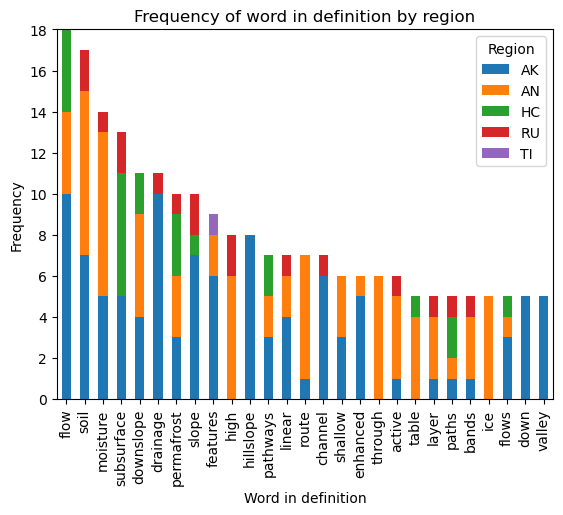

In [17]:
filtered_counts.loc[filtered_counts['sum'] > 4].sort_values('sum', ascending=False).drop('sum', axis=1).plot(kind='bar', stacked=True)

plt.xlabel('Word in definition')
plt.ylabel('Frequency')
plt.title('Frequency of word in definition by region')
plt.legend(title='Region')
plt.ylim(0,18)